In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
!rm -rf original.model

In [2]:
from zipfile import ZipFile
zip = ZipFile('/content/drive/MyDrive/Tech_seminar/Gender1.zip')
zip.extractall()

In [3]:
import cv2
import subprocess
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.datasets import mnist

In [4]:
w, h = 64, 64
c = 3
batch_size = 64
no_epochs = 5000
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0
number_of_visualizations = 6
input_shape = (w, h, c)

In [5]:
import os
def load_dataset():
  X = list()
  Y = list()
  # for folder in os.listdir('/content/Gender/Men'):
  for filename in os.listdir('/content/Gender/Men'):
    img = cv2.imread('/content/Gender/Men/' + filename, cv2.IMREAD_COLOR)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGB_img = cv2.resize(RGB_img, (w, h), cv2.INTER_AREA)
    X.append(RGB_img)
    Y.append('0')
  for filename in os.listdir('/content/Gender/Women'):
    img = cv2.imread('/content/Gender/Women/' + filename, cv2.IMREAD_COLOR)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGB_img = cv2.resize(RGB_img, (w, h), cv2.INTER_AREA)
    X.append(RGB_img)
    Y.append('1')
  X = np.array(X)
  Y = np.array(Y)
  X = X.astype('float32') / 255.0
  trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

In [ ]:
def load_dataset1():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], w, h, c))
  testX = testX.reshape((testX.shape[0], w, h, c))
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  trainX = trainX.astype('float32') / 255.0
  testX = testX.astype('float32') / 255.0
  return trainX[5000:5200], trainY[5000:5200], testX[1000:1050], testY[1000:1050]

In [6]:
def define_model(trainX):
  model = Sequential()

  model.add(Convolution2D(32, (3, 3), activation='relu',input_shape = trainX.shape[1:]))
  model.add(Convolution2D(32, (3, 3), activation='relu'))  
  # model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.1))

  model.add(Convolution2D(64, (3, 3), activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.1))

  model.add(Convolution2D(128, (3, 3), activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2,2)))

  # model.add(Convolution2D(256, (3, 3), activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.1))

  # model.add(Convolution2D(512, (3, 3), activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  # model.add(Dropout(0.1))

  model.add(Dense(2, activation = 'softmax'))
  return model

In [7]:
from keras.utils import to_categorical
trainX, trainY, testX, testY = load_dataset()
model = define_model(trainX)
model.summary()
print(len(trainX))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              411042816 
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

[1. 0.]


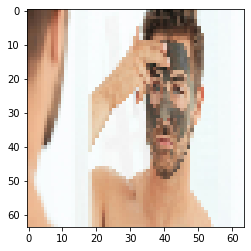

In [8]:
import matplotlib.pyplot as plt
print(testY[20])
img1 = (testX[20] * 255).astype(np.uint8)
img1 = img1.reshape(64,64,3)
plt.imshow(img1)

In [9]:
opt = keras.optimizers.Adam(learning_rate=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model = keras.models.load_model('/content/original1.model')
model.compile(
    optimizer="adam",
  loss='categorical_crossentropy',
  metrics=['accuracy'])
early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint("original1.model", verbose=1) # , save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1)

In [ ]:
history = model.fit(trainX, trainY, shuffle=True, epochs=200, batch_size=64, validation_split = 0.2, callbacks=[model_checkpoint], verbose=1)
model.save('original1.model')

# !zip -r /content/original1.model.zip /content/original1.model.model
from google.colab import files
files.download("/content/original1.model")

In [ ]:
!zip -r /content/original.model.zip /content/original.model
# from google.colab import files
# files.download("/content/original.model.zip")

In [ ]:
from google.colab import files
files.download("/content/original.model")

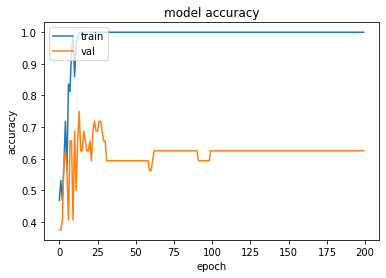

In [11]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

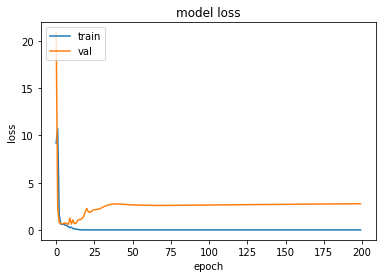

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
predicted_score = model.predict(testX)
score = model.evaluate(testX, testY)
print("test loss, test acc:", score)

2/2 [==============================] - 2s 483ms/step - loss: 2.3303 - accuracy: 0.6500
test loss, test acc: [2.330308437347412, 0.6499999761581421]


In [ ]:
predicted_score

array([[0.12588751, 0.09995513, 0.09549056, ..., 0.10555751, 0.10526966,
        0.09564757],
       [0.12588751, 0.09995513, 0.09549056, ..., 0.10555751, 0.10526966,
        0.09564757],
       [0.12588751, 0.09995513, 0.09549056, ..., 0.10555751, 0.10526966,
        0.09564757],
       ...,
       [0.12588751, 0.09995513, 0.09549056, ..., 0.10555751, 0.10526966,
        0.09564757],
       [0.12588751, 0.09995513, 0.09549056, ..., 0.10555751, 0.10526966,
        0.09564757],
       [0.12588751, 0.09995513, 0.09549056, ..., 0.10555751, 0.10526966,
        0.09564757]], dtype=float32)

In [ ]:
(trainx, trainy), (testx, testy) = mnist.load_data()
# trainx = trainx.reshape((trainx.shape[0], w, h, c))
# testx = testx.reshape((testx.shape[0], w, h, c))
# # one hot encode target values
# # trainY = to_categorical(trainY)
# # testY = to_categorical(testY)
# trainx = trainx.astype('float32') / 255.0
# testx = testx.astype('float32') / 255.0


In [ ]:
img = testX[0].reshape(1, 28, 28, 1)

In [ ]:
y = testX[0]

[[6.8005215e-07 9.9999928e-01]]
[0. 1.]


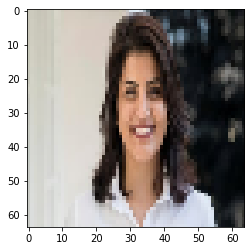

In [22]:
n = 2
img1 = (testX[n] * 255).astype(np.uint8)
img1 = img1.reshape(64,64,3)
plt.imshow(img1)
# img = np.expand_dims(trainx[1], axis=0)
# img = img.astype('float32')
# img = testx[0].reshape(1,testx[0].shape)
img = testX[n].reshape(1, 64, 64, 3)
x = model.predict(img)
print(x)
print(testY[n])